In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, roc_curve
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline


# Read CSV
data = pd.read_csv('OnlineNewsPopularity_ForModeling.csv',index_col='url')

In [2]:
def plot_confusion_matrix(cm,classes,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    Prints and plots a confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def popularity(data,thresh,col_name):
    """
    Labels data as 'popular' or 'unpopular' based on a given threshold.
    """
    data.loc[data[(data['shares'] > thresh)].index,col_name] = 'popular'
    data.loc[data[data['shares'] <= thresh].index,col_name] = 'unpopular'
    return data.drop(columns='shares')

def lim_entries(data,col_name,both=False):
    """
    Limits data so that the number of entries in a given column are equal.
    """
    entries = data[col_name].value_counts().index[:-1]
    n = data[col_name].value_counts()[-1]
    new = data.loc[data[col_name] == data[col_name].value_counts().index[-1]]
    
    for entry in entries:
        selected = data[data[col_name] == entry].reset_index()
        selected_col = selected.columns
        index = selected_col[0]
        selected = pd.DataFrame(np.random.permutation(selected)[:n],columns=selected_col).set_index(index)
        new = new.append(selected)  
    if both == True:
        new = [new,data.drop(index=list(new.index))]
    return new

def split_data(data,thresh,y_var='popularity'):
    """
    Labels entries as popular and unpopular given a certain threshold then limits data such that 
    the two labels have an equal amount of entries. Then splits data into training and testing
    sets. 
    """
    data = popularity(data,thresh=thresh,col_name=y_var)
    data, cut_data = lim_entries(data,col_name=y_var,both=True)
    
    # use the selected y_var to seperate the X and Y variables
    y_var_values = data[y_var].unique()
    X = data.drop(columns=y_var)
    y = data[y_var].replace(y_var_values,range(len(y_var_values)))
    
    X_cut = cut_data.drop(columns=y_var)
    y_cut = cut_data[y_var].replace(y_var_values,range(len(y_var_values)))
    
    cut_data = [X_cut,y_cut]

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30,stratify=y)
    
    return X_train, X_test, y_train, y_test, cut_data


def best_depth(X,y,k):
    """
    Finds best depth of the model based off of the 
    """
    pipe = Pipeline(steps=[('scaler', StandardScaler()), ('random_forest', RandomForestClassifier())])
    grid = GridSearchCV(pipe,param_grid={'random_forest__max_depth':k},scoring='recall')
    grid.fit(X,y)
    return grid

def make_model(X,y,krange=range(5,15)):
    """
    Makes a random forest model based off the best K.
    """
    grid = best_depth(X.copy(),y.copy(),krange)

    k = grid.best_params_['random_forest__max_depth']
    
    pipe = Pipeline(steps=[('scaler', StandardScaler()), ('random_forest', RandomForestClassifier(max_depth=k))])
    pipe.fit(X,y)
    return pipe
    
def test_model(model, X, y,feat_importance=False):
    """
    Plots confusion matrix, roc curve, and f1 scores
    """
    y_var_values = ['popular','unpopular']
    
    if type(X) == tuple:
        X_train,X_test = X
        y_train,y_test = y
    
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
    
        y_pred_train_proba = model.predict_proba(X_train)[:, 1]
        y_pred_test_proba = model.predict_proba(X_test)[:, 1]
    
        # f1 score
        training_accuracy = f1_score(y_train, y_pred_train)
        test_accuracy = f1_score(y_test, y_pred_test)
        print(training_accuracy,test_accuracy)
        # confusion matrix
        cnf_matrix_test = confusion_matrix(y_test, y_pred_test)
        cnf_matrix_train = confusion_matrix(y_train, y_pred_train)
        # roc curve
        fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train_proba)
        fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_test_proba)
        
        plt.figure(figsize=(10,10),dpi=200)
        plt.subplots_adjust(hspace=0.5,wspace=0.5)
    
        plt.subplot(221)
        plot_confusion_matrix(cnf_matrix_train,classes=y_var_values, title='Train Confusion matrix')
    
        plt.subplot(222)
        plot_confusion_matrix(cnf_matrix_test,classes=y_var_values, title='Test Confusion matrix')
        
        plt.subplot(223)
        plt.title('Train ROC')
        plt.plot(fpr_train, tpr_train)
        plt.xlabel('False Positive Rate')
        plt.xlabel('True Positive Rate')
    
        plt.subplot(224)
        plt.title('Test ROC')
        plt.plot(fpr_test, tpr_test)
        
    else:
        
        y_pred = model.predict(X)
        y_pred_proba = model.predict_proba(X)[:, 1]
    
        # f1 score
        accuracy = f1_score(y, y_pred)
        print(accuracy)
        # confusion matrix
        cnf_matrix= confusion_matrix(y, y_pred)
        # roc curve
        fpr, tpr, _ = roc_curve(y, y_pred_proba)
        
        plt.figure(figsize=(10,5),dpi=200)
        plt.subplots_adjust(hspace=0.5,wspace=0.5)
    
        plt.subplot(121)
        plot_confusion_matrix(cnf_matrix,classes=y_var_values, title='Confusion matrix')

        plt.subplot(122)
        plt.title('ROC')
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.xlabel('True Positive Rate')

        if feat_importance == True:
            plt.figure(figsize=(10,5),dpi=200)
            plt.title('Feature Importance - Top 10')
            features = pd.Series(model.steps[1][1].feature_importances_,index=X.columns).sort_values(ascending=False)
            features[:10].plot(kind='bar')

# 95th Percentile

0.9938428105758783 0.776595744680851


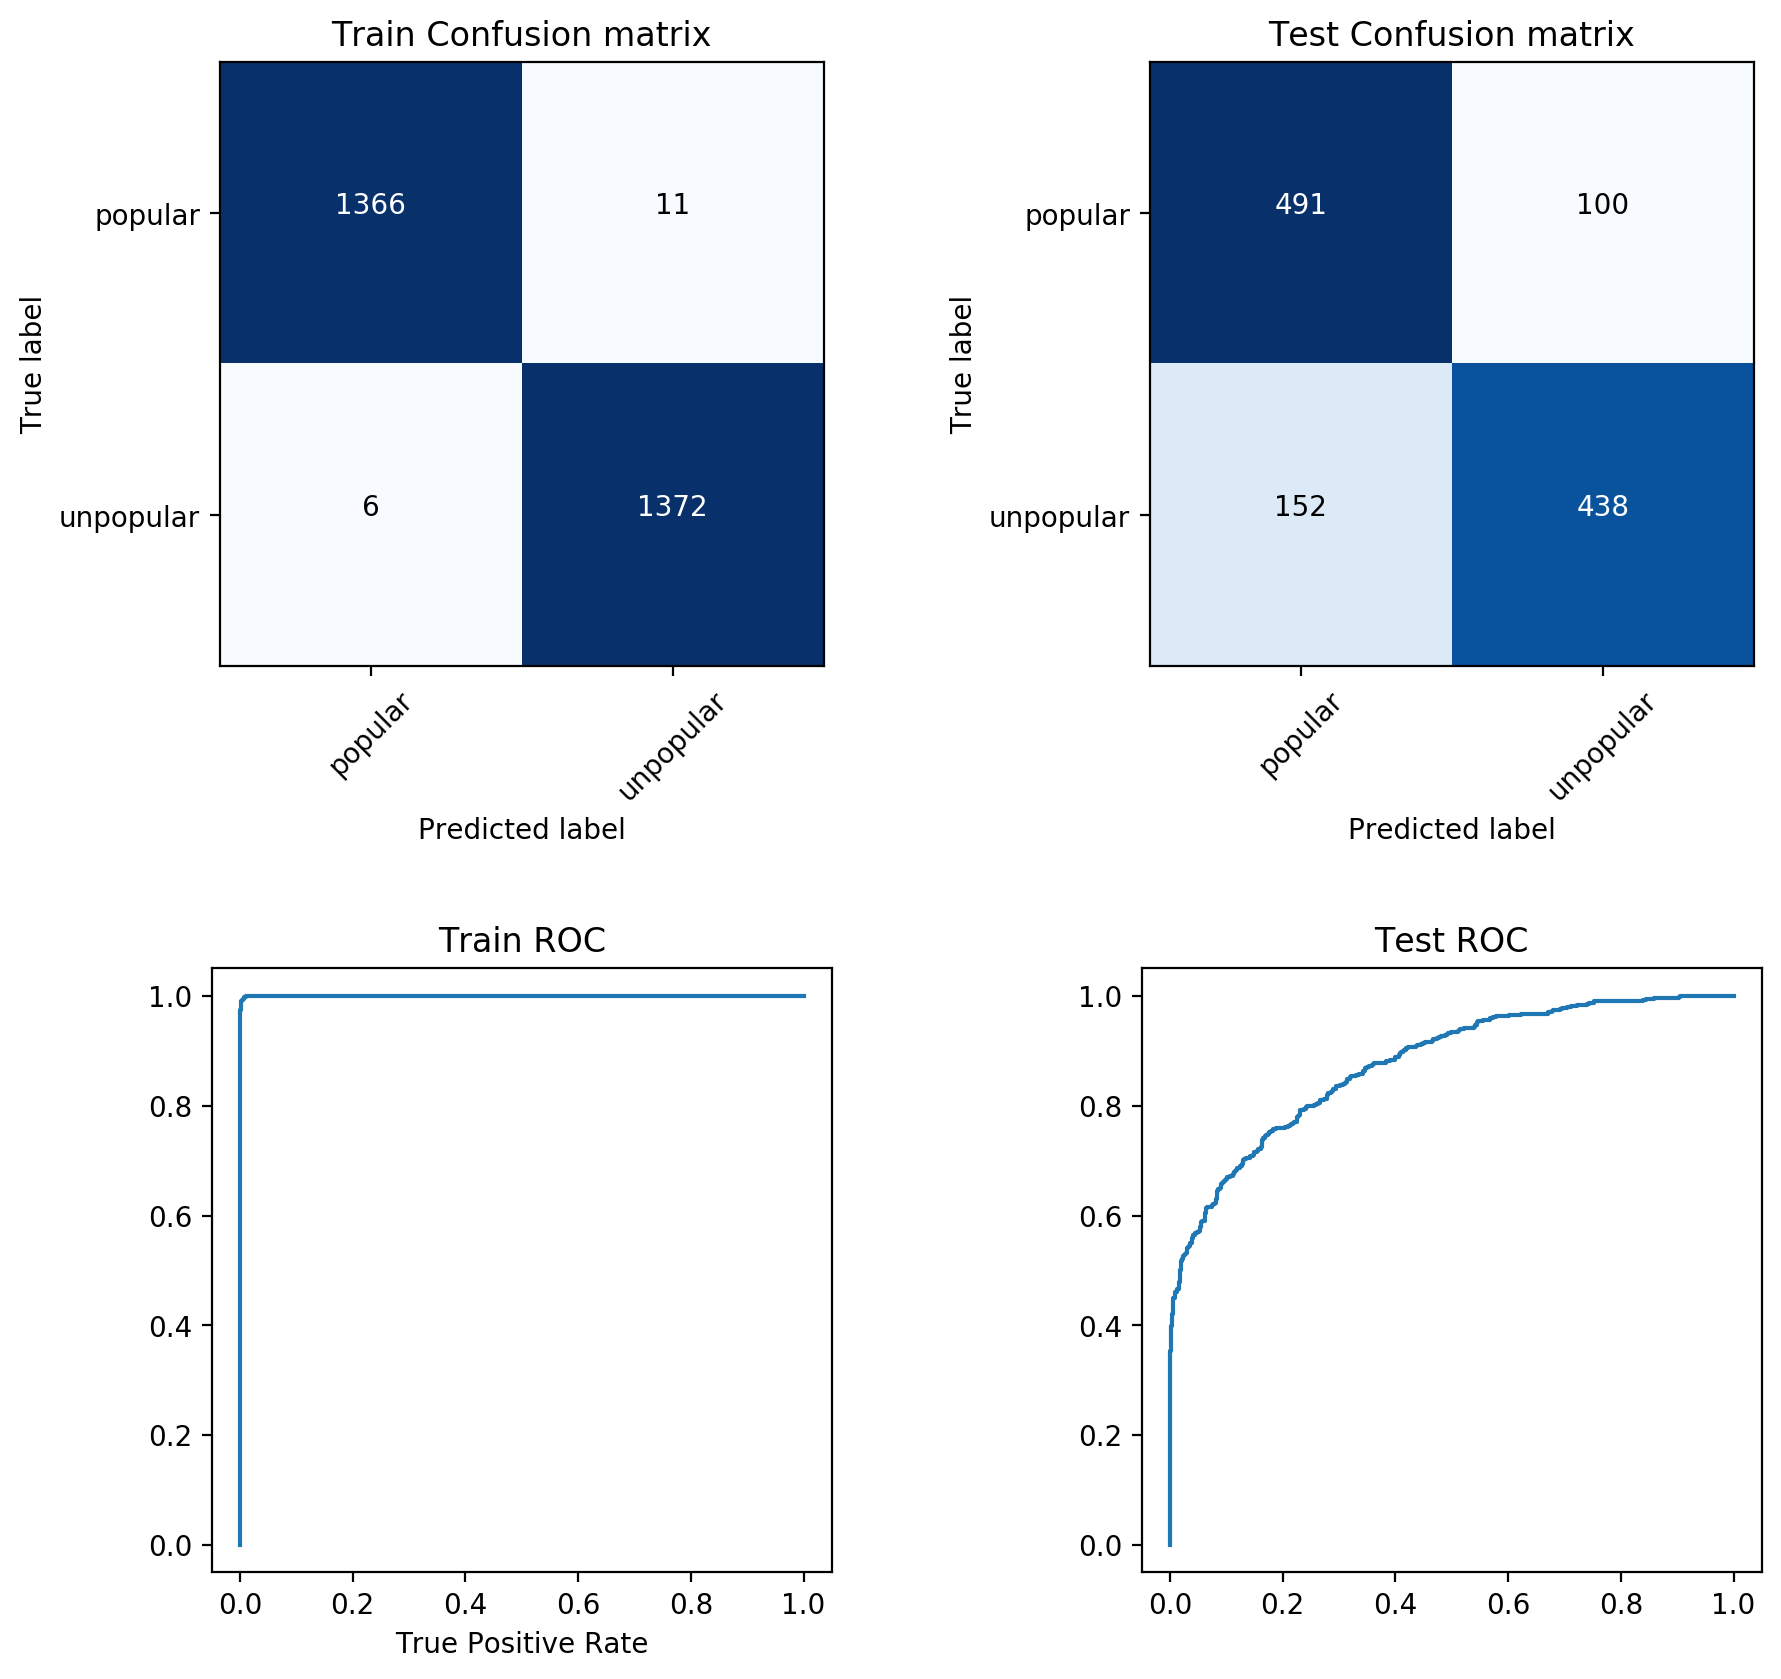

In [3]:
# Set threshold of popularity to above the 95th percentile
thresh = np.percentile(data.shares,[0,95])[1]

# train model on limited points
X_train, X_test, y_train, y_test, cut_data = split_data(data.copy(),thresh,'popularity')

model = make_model(X_train,y_train,krange=range(5,15))
test_model(model,(X_train, X_test), (y_train, y_test))

0.9938428105758783 0.8545823041357906


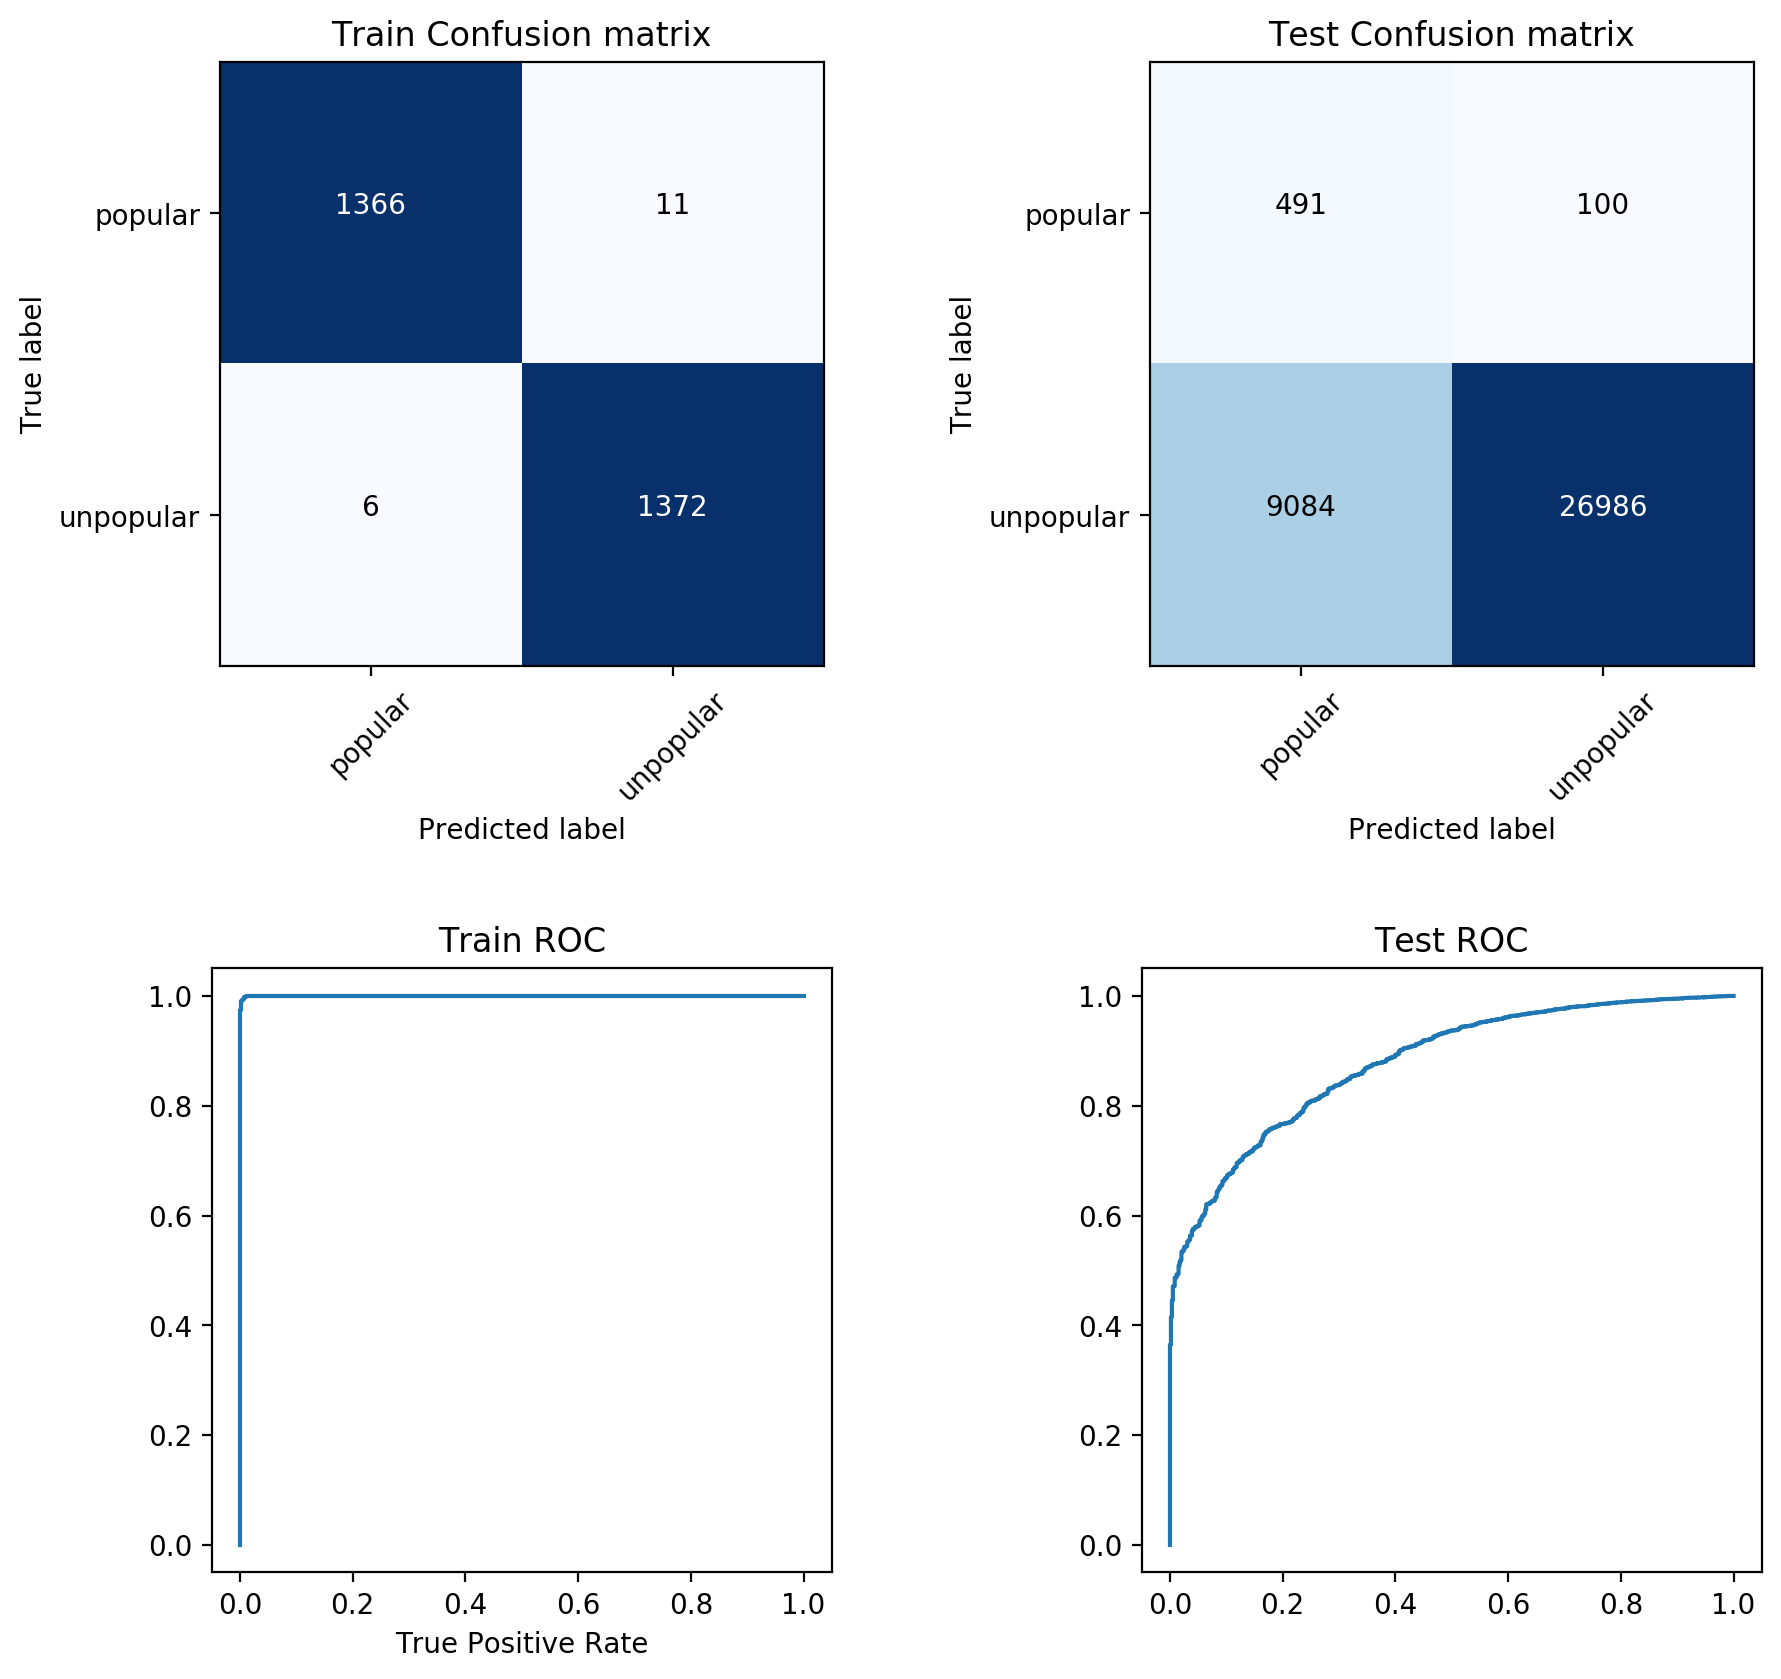

In [4]:
# test it with all cut points added once to testing data
X_test_all = X_test.append(cut_data[0])
y_test_all = y_test.append(cut_data[1])

test_model(model,(X_train, X_test_all), (y_train, y_test_all))

# 99th Percentile

0.9963503649635036 0.9009259390553437


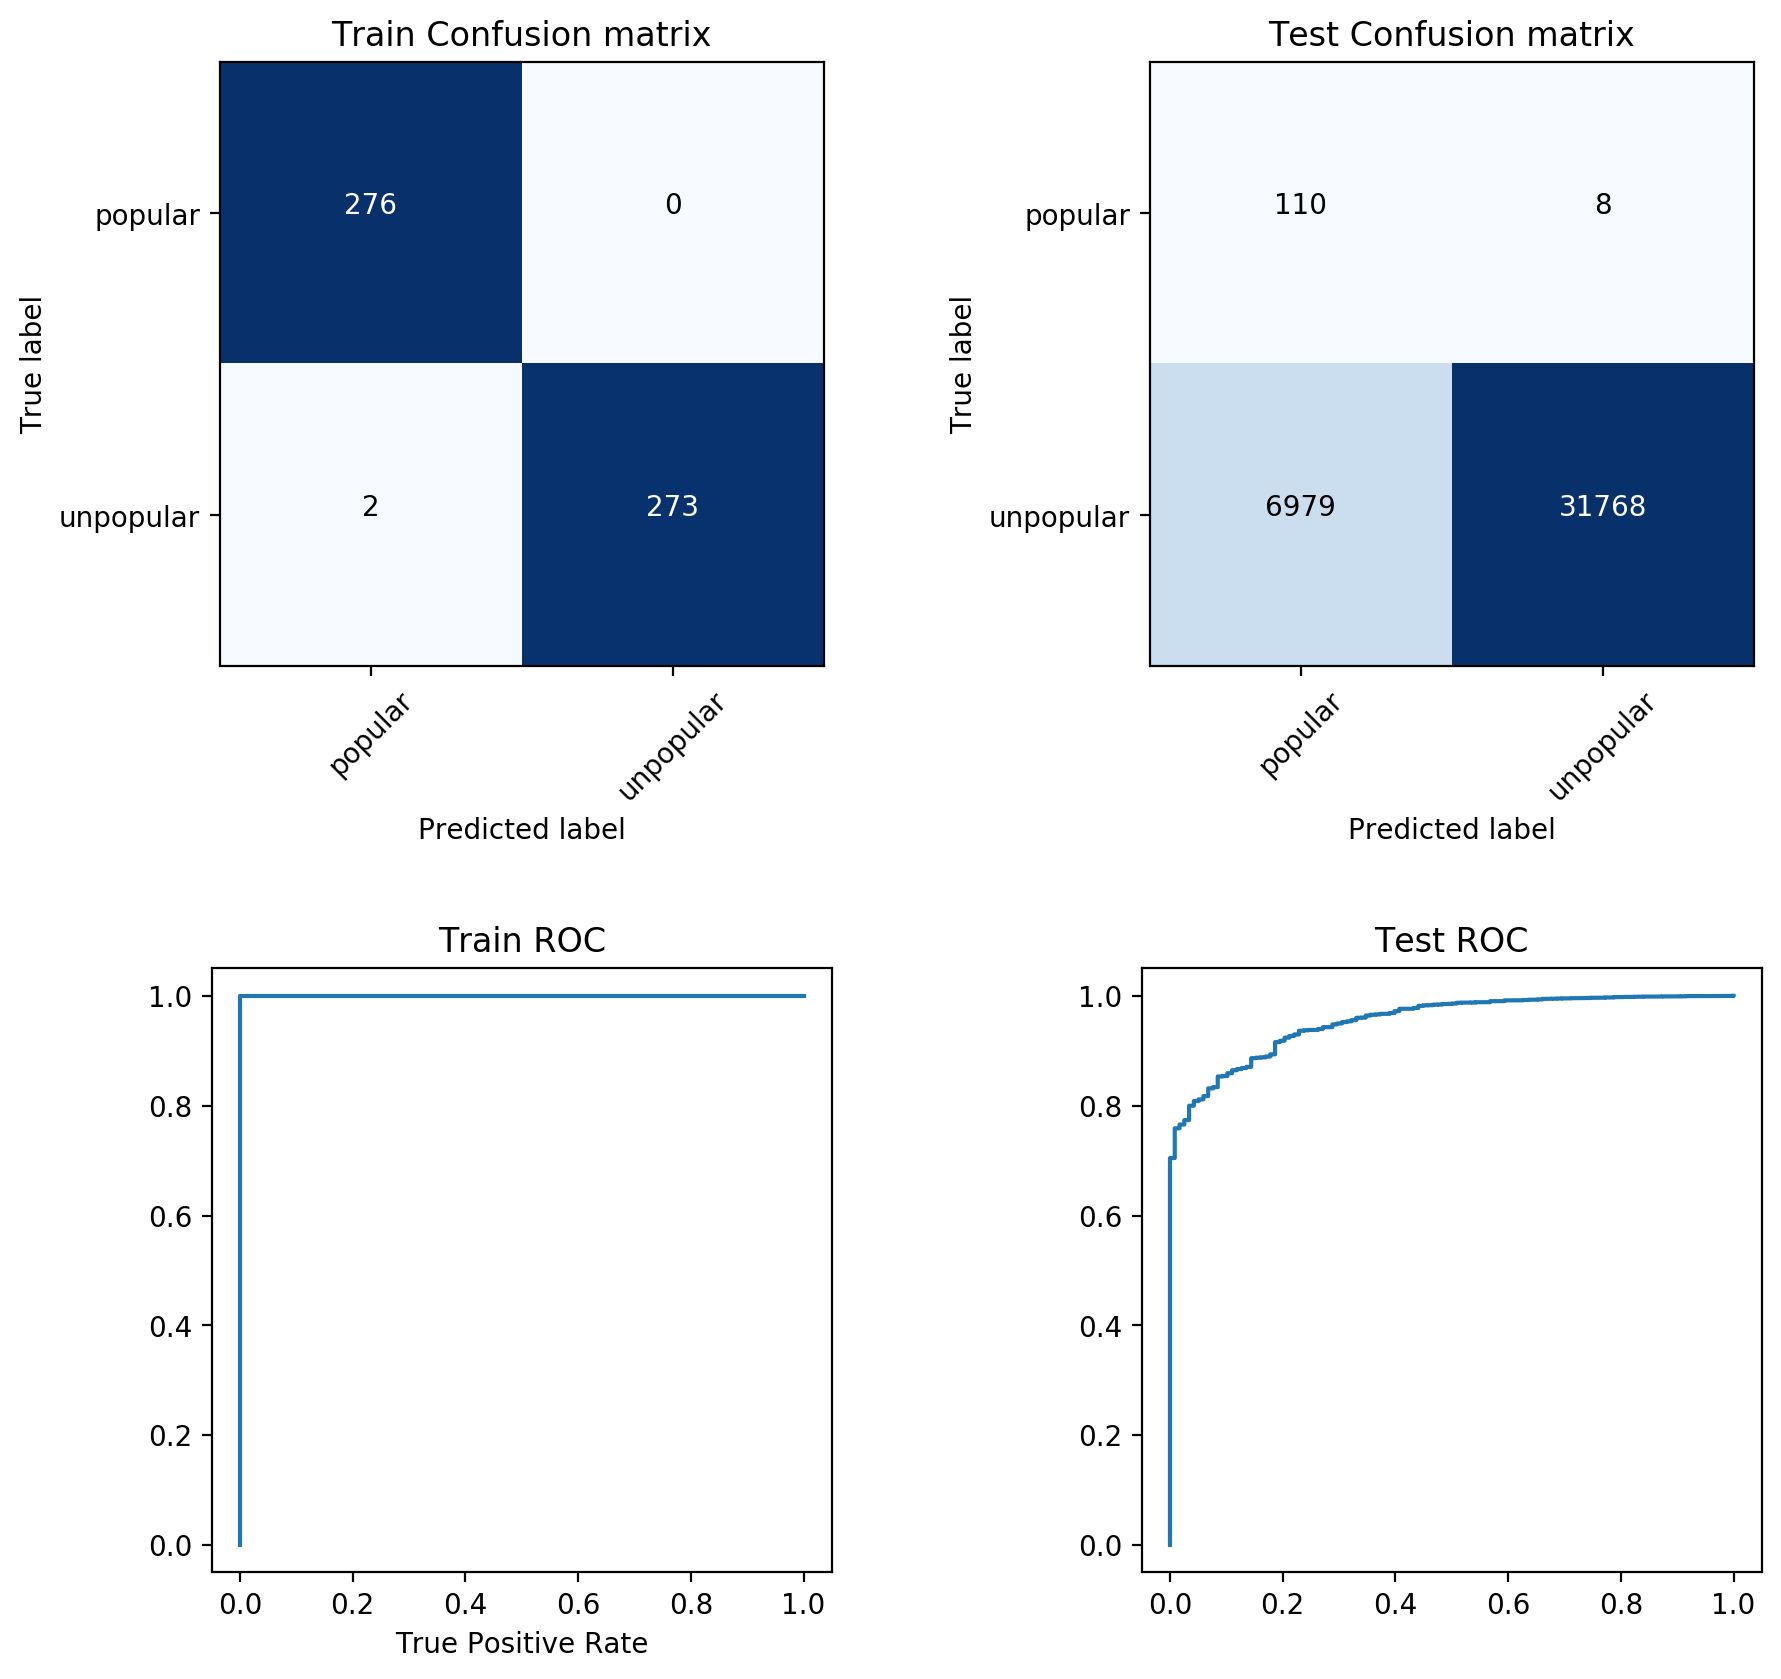

In [5]:
# Set threshold of popularity to above the 99th percentile
thresh = np.percentile(data.shares,[0,99])[1]
k = range(5,10)

X_train, X_test, y_train, y_test, cut_data = split_data(data.copy(),thresh,'popularity')
model = make_model(X_train,y_train,krange=k)

X_test_all = X_test.append(cut_data[0])
y_test_all = y_test.append(cut_data[1])

test_model(model,(X_train, X_test_all), (y_train, y_test_all))

# Final Model

1.0


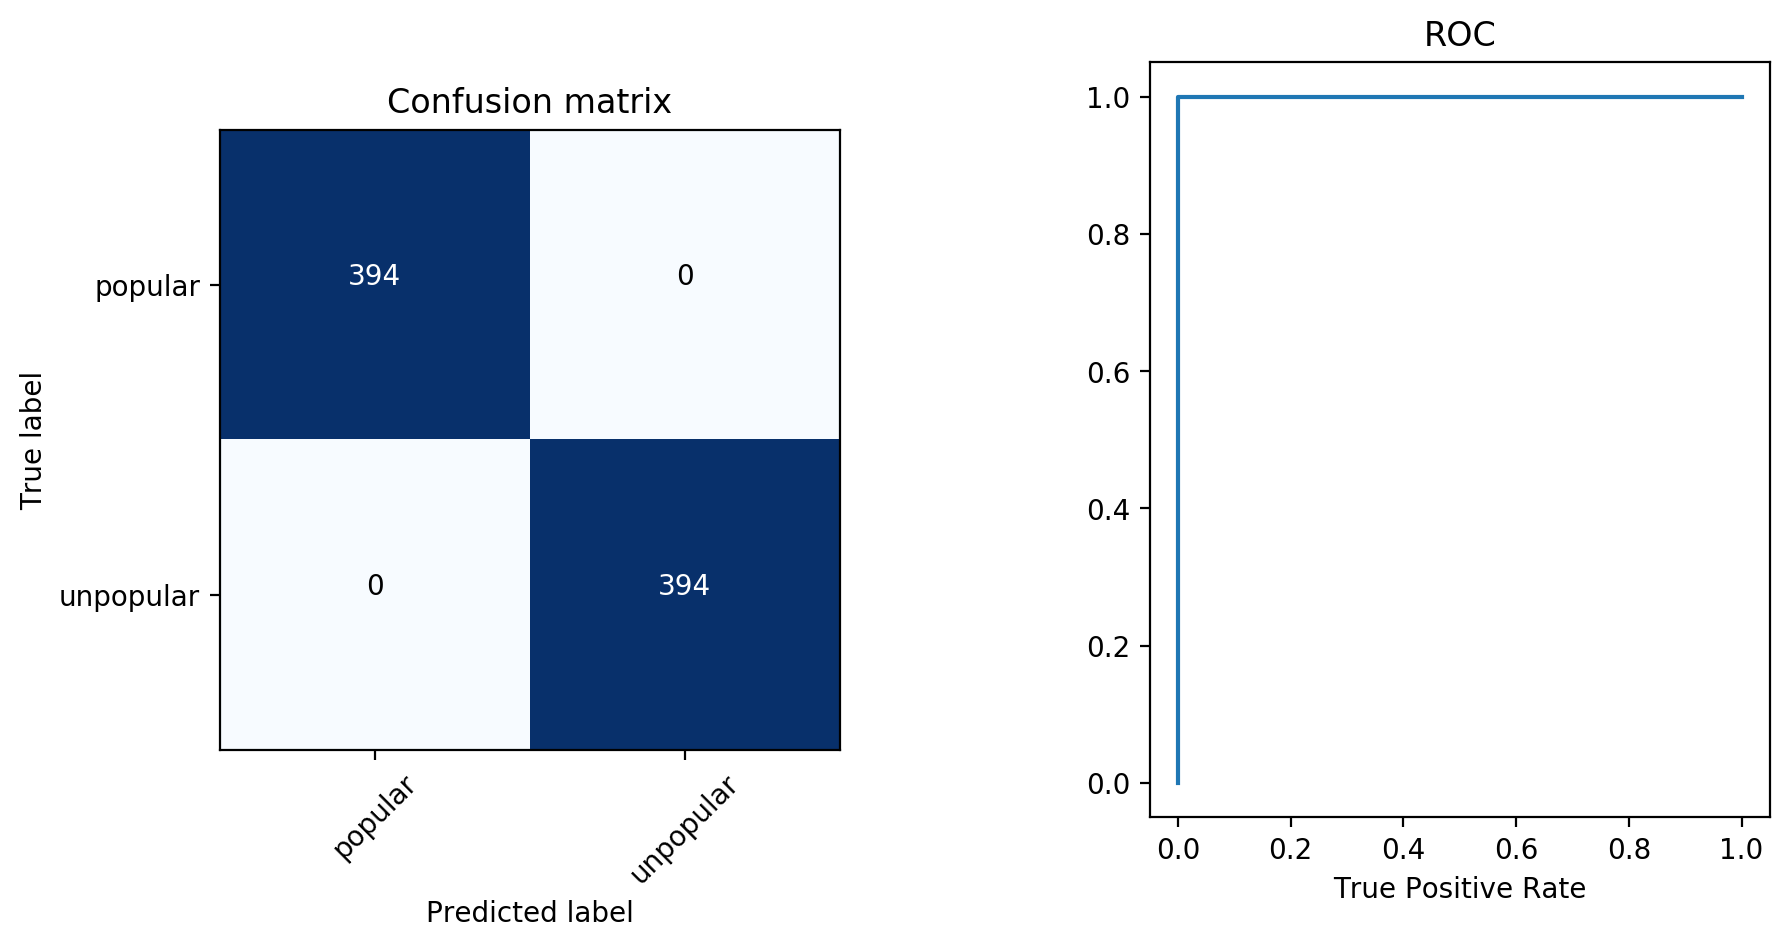

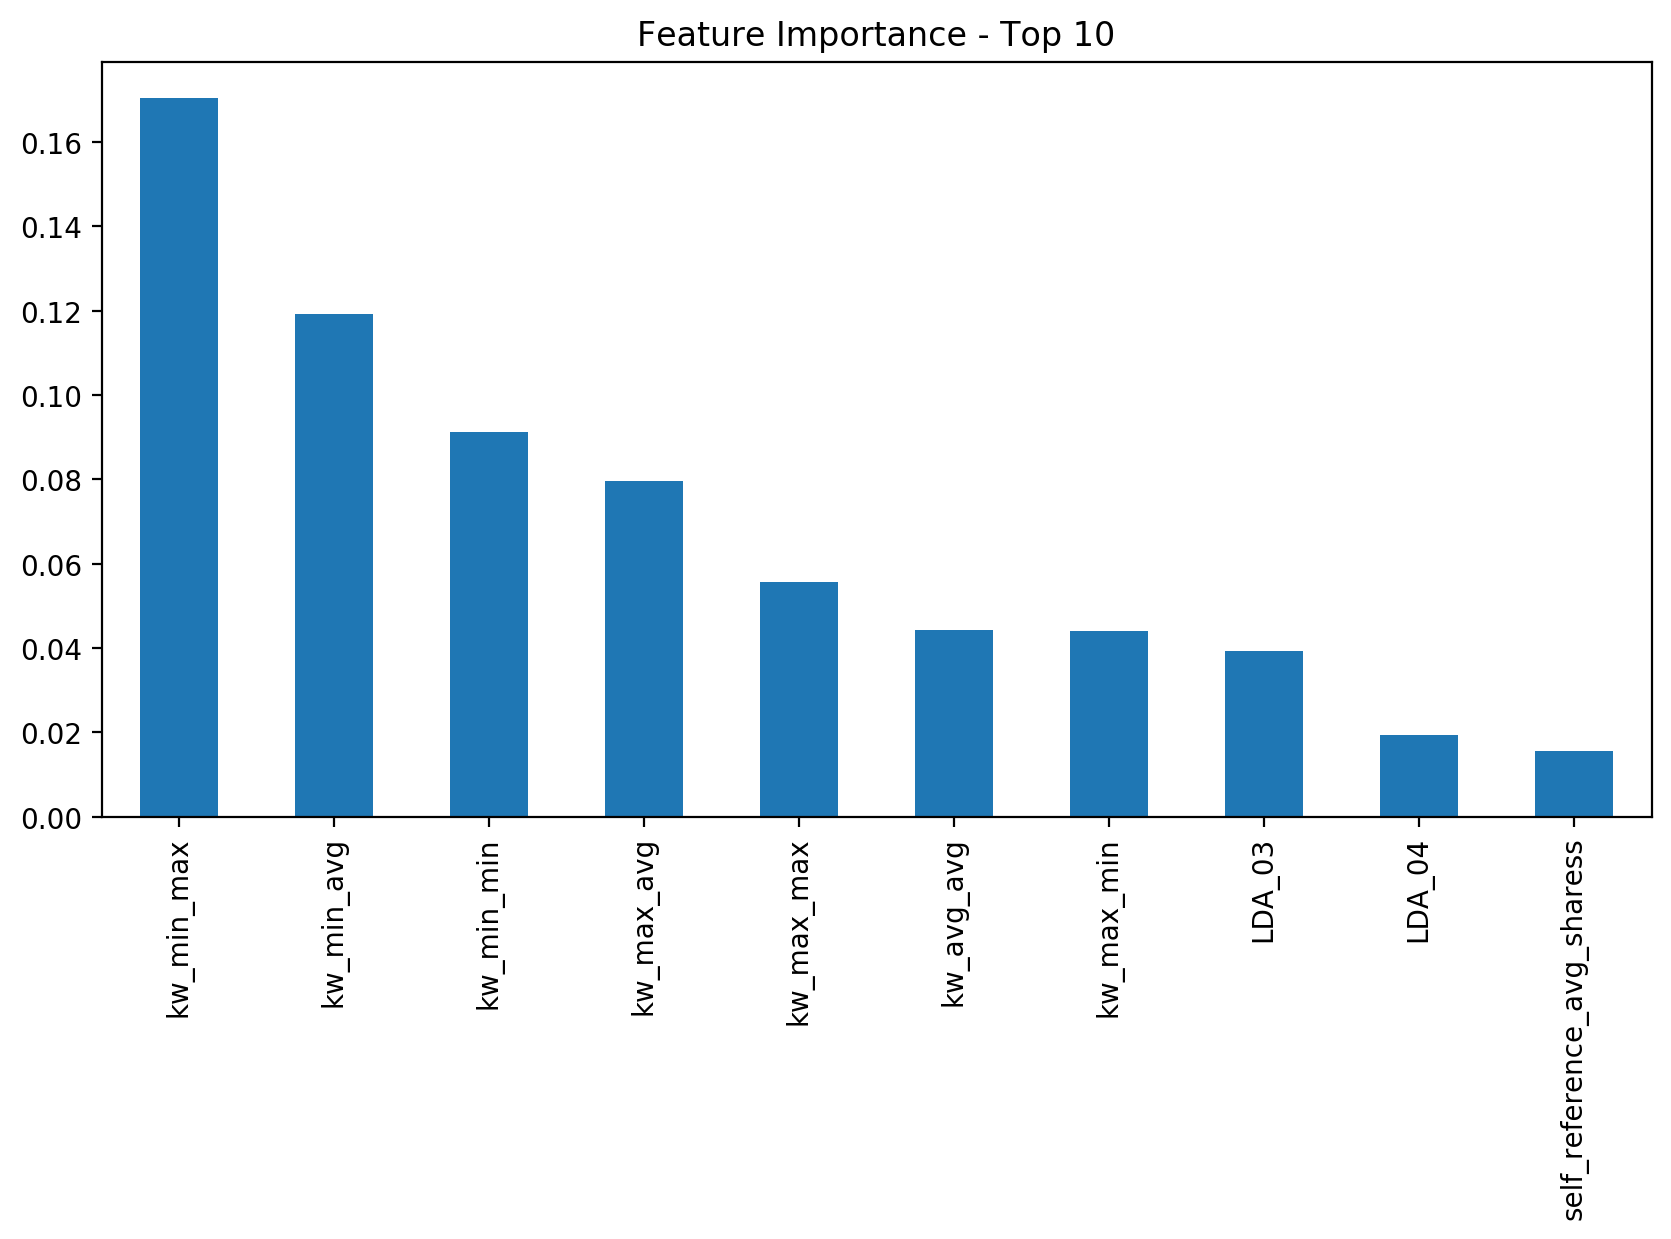

In [6]:
# Set threshold of popularity to above the 95th percentile
thresh = np.percentile(data.shares,[0,99])[1]

X_train, X_test, y_train, y_test, cut_data = split_data(data.copy(),thresh,'popularity')

X = X_train.append(X_test)
y = y_train.append(y_test)

model = make_model(X,y)

test_model(model,X,y,feat_importance= True)